In [1]:
import os
import torch
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix
from torch_geometric.data import Data, DataLoader
from torch_geometric.loader import DataLoader as GeoDataLoader
from sklearn.utils.class_weight import compute_class_weight

from model import *
from utils import *

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## Count images without adjacencies

In [2]:
def count_valid_files(directory):
    return sum(1 for filename in os.listdir(directory) if not filename.startswith('.') and os.path.isfile(os.path.join(directory, filename)))

image_data_dir = './Image_data/DATASET/train'
image_lengths = {subdir: count_valid_files(os.path.join(image_data_dir, subdir)) for subdir in os.listdir(image_data_dir) if not subdir.startswith('.') and os.path.isdir(os.path.join(image_data_dir, subdir))}

adjacency_dir = './output_data/adjacency'
adjacency_lengths = {subdir: count_valid_files(os.path.join(adjacency_dir, subdir)) for subdir in os.listdir(adjacency_dir) if not subdir.startswith('.') and os.path.isdir(os.path.join(adjacency_dir, subdir))}

print("Image data lengths:")
print(image_lengths)

print("Adjacency data lengths:")
print(adjacency_lengths)

Image data lengths:
{'1': 1290, '2': 281, '3': 717, '4': 4772, '5': 1982, '6': 705, '7': 2524}
Adjacency data lengths:
{'adjacency_1': 1165, 'adjacency_2': 241, 'adjacency_3': 256, 'adjacency_4': 1915, 'adjacency_5': 664, 'adjacency_6': 524, 'adjacency_7': 2127}


## label setting

In [25]:
# Set directory paths
dir_1 = './output_data/adjacency/adjacency_1'
dir_2 = './output_data/adjacency/adjacency_2'
dir_3 = './output_data/adjacency/adjacency_3'
dir_4 = './output_data/adjacency/adjacency_4'
dir_5 = './output_data/adjacency/adjacency_5'
dir_6 = './output_data/adjacency/adjacency_6'
dir_7 = './output_data/adjacency/adjacency_7'

image_dir = './Image_data/DATASET/train'

dir_label_map = {
    '1': (dir_1, 0),
    '2': (dir_2, 1),
    '3': (dir_3, 2),
    '4': (dir_4, 3),
    '5': (dir_5, 4),
    '6': (dir_6, 5),
    '7': (dir_7, 6),
}

data_dict = {str(i): [] for i in range(1, 8)}
num_node_features = 21

def process_files(directory, label, image_dir, data_dict, key):
    adjacency_files = set(f.replace('adjacency_matrix_', '').replace('.jpg.csv', '') for f in os.listdir(directory) if f.endswith('.csv'))
    image_files = set(f.replace('.jpg', '') for f in os.listdir(os.path.join(image_dir, key)) if f.endswith('.jpg'))

    # Image with no adj unique_id
    missing_adj = image_files - adjacency_files
    
    for unique_id in image_files:
        image_path = os.path.join(image_dir, key, f'{unique_id}.jpg')
        file_path = os.path.join(directory, f'adjacency_matrix_{unique_id}.jpg.csv')

        if unique_id in missing_adj:
            # No adj, use CNN only
            image_data = process_image(image_path)
            
            # for handling model error
            placeholder_x = torch.zeros(1, num_node_features)
            placeholder_index = torch.empty((2, 0), dtype=torch.long)
            placeholder_weight = torch.empty((0,), dtype=torch.float)
            
            data = Data(x=placeholder_x, edge_index=placeholder_index, edge_weight=placeholder_weight, image_features=image_data)
            data.y = torch.tensor([label])
            data_dict[key].append(data)
            
        elif os.path.exists(file_path) and os.path.exists(image_path):
            # Image with adjacency matrix
            data = process_adj_matrix(file_path, image_path)
            data.y = torch.tensor([label])
            data_dict[key].append(data)
            
        else:
            print(f"Unexpected missing file for {unique_id}")
            
for key, (directory, label) in dir_label_map.items():
    process_files(directory, label, image_dir, data_dict, key)

In [26]:
print("Image data lengths:")
print("Processed data")
print([len(data_dict[f'{i}']) for i in range(1, 8)])

Image data lengths:
Processed data
[1290, 281, 717, 4772, 1982, 705, 2524]


## Test the model propogation data_dict

In [100]:
# Without adj data

edge_weight = torch.empty(0)
edge_index = torch.empty(2, 0, dtype=torch.long)

if edge_index is not None and edge_weight is not None and edge_weight.numel() > 0:
    # GCN component
    print('not empty')
else:
    print('empty')

# with adj data

edge_weight = data_dict['1'][0].edge_weight
edge_index = data_dict['1'][0].edge_index
if edge_index is not None and edge_weight is not None and edge_weight.numel() > 0:
    # GCN component
    print('not empty')
else:
    print('empty')

empty
not empty


In [39]:
data_list = data_dict['1'] + data_dict['2'] + data_dict['3'] + data_dict['4'] + data_dict['5'] + data_dict['6'] + data_dict['7']

batch_size = 64

total_size = len(data_list)
train_size = int(0.8 * total_size)
val_size = total_size - train_size

train_data, val_data = random_split(data_list, [train_size, val_size])

# Step 2: Create DataLoader for training and validation
train_loader = GeoDataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = GeoDataLoader(val_data, batch_size=batch_size, shuffle=False)

# Step 3: Model setup
# Some of the datas don't have adj matrix
num_node_features = next(data.x.shape[1] for data in data_list if data.x is not None)

hidden_channels = 64

labels = [data.y.item() for data in data_list]  # 提取所有樣本的標籤
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

model = Net_Alex(num_node_features, hidden_channels).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

c:\Users\USER\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
# Initialize variables for cumulative predictions and labels
cumulative_preds = []
cumulative_labels = []

for epoch in range(1, num_epochs + 1):
    # Initialize epoch tracking variables
    model.train()
    total_loss = 0
    correct = 0

    # Training phase
    for batch in train_loader:
        batch = batch.to(device)

        x = batch.x
        edge_index = batch.edge_index
        edge_weight = batch.edge_weight
        image_features = batch.image_features
        batch_y = batch.y

        optimizer.zero_grad()
        
        out = model(x, edge_index, edge_weight, batch.batch, image_features)
        loss = criterion(out, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        _, pred = out.max(dim=1)
        correct += (pred == batch_y).sum().item()

    train_loss = total_loss / len(train_loader)
    train_accuracy = correct / len(train_data)

    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    epoch_preds = []
    epoch_labels = []
    
    with torch.no_grad():
        
        for batch in val_loader:
            batch = batch.to(device)

            x = batch.x
            edge_index = batch.edge_index
            edge_weight = batch.edge_weight
            image_features = batch.image_features
            batch_y = batch.y

            out = model(x, edge_index, edge_weight, batch.batch, image_features)
            loss = criterion(out, batch_y)
            val_loss += loss.item()

            _, pred = out.max(dim=1)
            val_correct += (pred == batch_y).sum().item()

            # Collect predictions and labels for this epoch
            epoch_preds.extend(pred.cpu().numpy())
            epoch_labels.extend(batch_y.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / len(val_data)

    # Logging results for each epoch
    print(f'Epoch {epoch}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
    
    # Accumulate all predictions and labels across epochs
    cumulative_preds.extend(epoch_preds)
    cumulative_labels.extend(epoch_labels)

Epoch 1/10, Train Loss: 1.5900, Train Acc: 0.4207, Val Loss: 1.3133, Val Acc: 0.5381
Epoch 2/10, Train Loss: 1.2720, Train Acc: 0.5532, Val Loss: 1.2090, Val Acc: 0.5699
Epoch 3/10, Train Loss: 1.1542, Train Acc: 0.6010, Val Loss: 1.1281, Val Acc: 0.5947
Epoch 4/10, Train Loss: 1.0511, Train Acc: 0.6399, Val Loss: 1.0384, Val Acc: 0.6509
Epoch 5/10, Train Loss: 0.9449, Train Acc: 0.6797, Val Loss: 0.9135, Val Acc: 0.6884
Epoch 6/10, Train Loss: 0.8989, Train Acc: 0.6918, Val Loss: 0.8501, Val Acc: 0.7018
Epoch 7/10, Train Loss: 0.8351, Train Acc: 0.7212, Val Loss: 0.8213, Val Acc: 0.7181
Epoch 8/10, Train Loss: 0.7863, Train Acc: 0.7375, Val Loss: 0.8537, Val Acc: 0.7279
Epoch 9/10, Train Loss: 0.7423, Train Acc: 0.7507, Val Loss: 0.8636, Val Acc: 0.6994
Epoch 10/10, Train Loss: 0.6931, Train Acc: 0.7702, Val Loss: 0.7911, Val Acc: 0.7226


In [6]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [34]:
test_pth = [
    'Image_data/DATASET/test/1/test_0002_aligned.jpg',
    'Image_data/DATASET/test/2/test_0274_aligned.jpg',
    'Image_data/DATASET/test/3/test_0007_aligned.jpg',
    'Image_data/DATASET/test/4/test_0003_aligned.jpg',
    'Image_data/DATASET/test/5/test_0001_aligned.jpg',
    'Image_data/DATASET/test/6/test_0017_aligned.jpg',
    'Image_data/DATASET/test/7/test_2389_aligned.jpg'
]

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class NetWrapper(nn.Module):
    def __init__(self, model, edge_index, edge_weight, batch):
        super(NetWrapper, self).__init__()
        self.model = model
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        self.batch = batch

    def forward(self, image_features):
        return self.model(None, self.edge_index, self.edge_weight, self.batch, image_features)

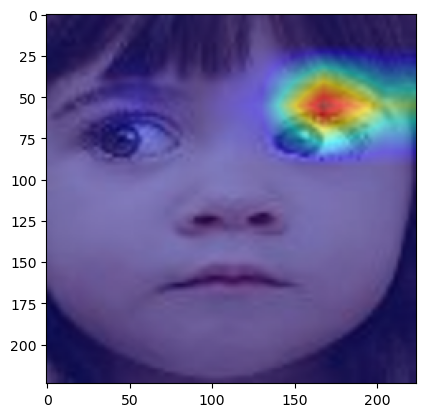

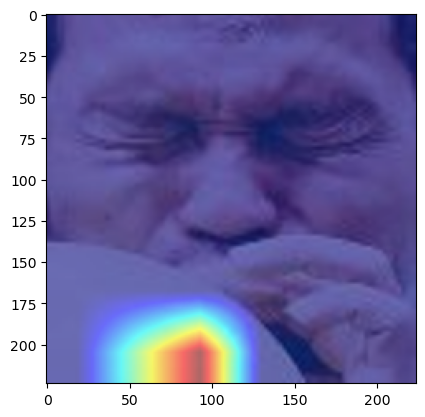

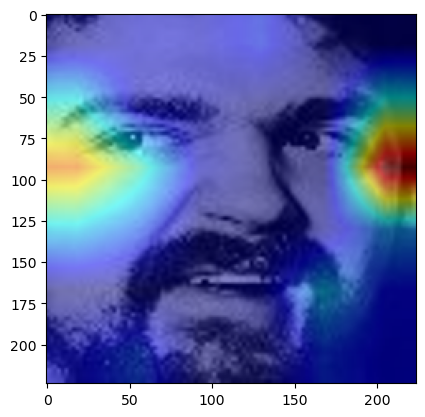

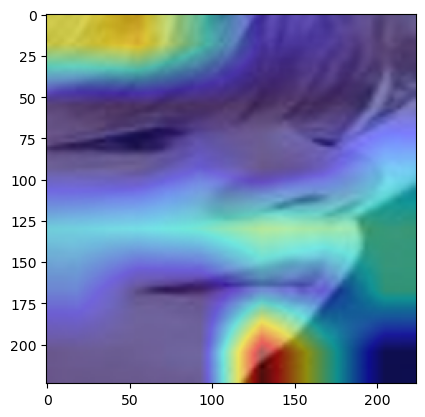

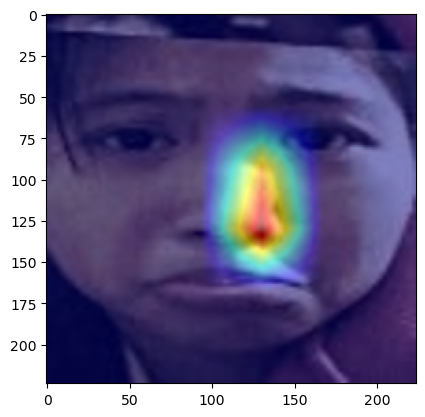

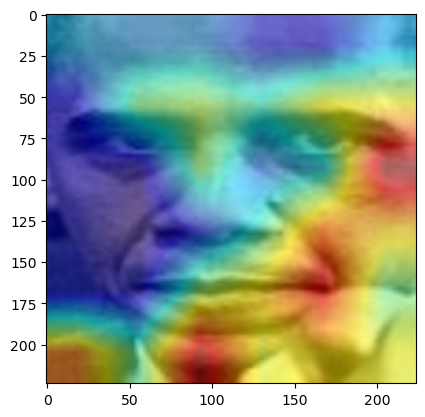

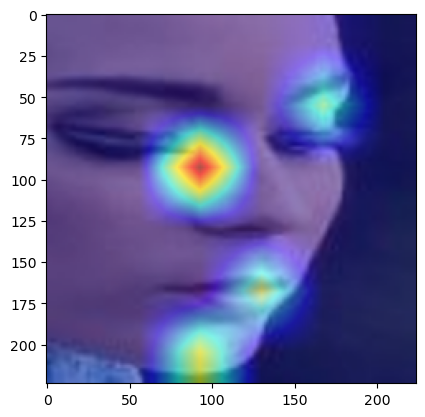

In [41]:
for index, pth in enumerate(test_pth):

    input_image = Image.open(pth)
    input_tensor = transform(input_image).unsqueeze(0)  # Add batch dimension
    rgb_img = np.array(input_image.resize((224, 224))) / 255.0

    # model = Net_Alex(num_node_features, hidden_channels).to(device)

    edge_weight = data_dict['1'][0].edge_weight
    edge_index = data_dict['1'][0].edge_index
    batch = val_loader.dataset[0]

    wrapped_model = NetWrapper(model, edge_index, edge_weight, batch)

    target_layers = [wrapped_model.model.alexnet.features[-1]]

    cam = GradCAM(model=wrapped_model, target_layers=target_layers)

    grayscale_cam = cam(input_tensor=input_tensor)

    visualization = show_cam_on_image(rgb_img, grayscale_cam[0, :], use_rgb=True)
    plt.imshow(visualization)
    plt.show()

    # save the plot
    # plt.imsave(f'GradCam/netalex_{index + 1}.png', visualization)

In [18]:
class AlexNetModified(nn.Module):
    def __init__(self, num_classes=7):
        super(AlexNetModified, self).__init__()
        self.alexnet = models.alexnet(pretrained=True)
        # 替换分类器的最后一层
        num_features = self.alexnet.classifier[6].in_features
        self.alexnet.classifier[6] = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.alexnet(x)
    
model = AlexNetModified(num_classes=7).to(device)

In [19]:
num_classes = 7  # Update based on your specific number of classes

# Model setup
model = AlexNetModified(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Initialize variables for cumulative predictions and labels
cumulative_preds = []
cumulative_labels = []

def train(model, device, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0

    for batch in train_loader:
        batch = batch.to(device)

        # Use only image_features and labels
        image_features = batch.image_features
        labels = batch.y

        optimizer.zero_grad()
        output = model(image_features)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += (pred == labels).sum().item()

    return total_loss / len(train_loader), correct / len(train_loader.dataset)


def validate(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0
    correct = 0

    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)

            # Use only image_features and labels
            image_features = batch.image_features
            labels = batch.y

            output = model(image_features)
            val_loss += criterion(output, labels).item()
            pred = output.argmax(dim=1)
            correct += (pred == labels).sum().item()

    return val_loss / len(val_loader), correct / len(val_loader.dataset)

In [22]:
model = AlexNetModified(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 25

# Training loop
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train(model, device, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, device, val_loader, criterion)
    print(f"Epoch {epoch}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/25: Train Loss: 1.6744, Train Acc: 0.3814, Val Loss: 1.6584, Val Acc: 0.3829
Epoch 2/25: Train Loss: 1.6428, Train Acc: 0.3904, Val Loss: 1.6599, Val Acc: 0.3829
Epoch 3/25: Train Loss: 1.6449, Train Acc: 0.3904, Val Loss: 1.6593, Val Acc: 0.3829
Epoch 4/25: Train Loss: 1.6443, Train Acc: 0.3904, Val Loss: 1.6617, Val Acc: 0.3829
Epoch 5/25: Train Loss: 1.6423, Train Acc: 0.3904, Val Loss: 1.6597, Val Acc: 0.3829
Epoch 6/25: Train Loss: 1.6407, Train Acc: 0.3904, Val Loss: 1.6666, Val Acc: 0.3829
Epoch 7/25: Train Loss: 1.6410, Train Acc: 0.3904, Val Loss: 1.6593, Val Acc: 0.3829
Epoch 8/25: Train Loss: 1.6415, Train Acc: 0.3904, Val Loss: 1.6610, Val Acc: 0.3829
Epoch 9/25: Train Loss: 1.6401, Train Acc: 0.3904, Val Loss: 1.6620, Val Acc: 0.3829
Epoch 10/25: Train Loss: 1.6406, Train Acc: 0.3904, Val Loss: 1.6638, Val Acc: 0.3829
Epoch 11/25: Train Loss: 1.6400, Train Acc: 0.3904, Val Loss: 1.6579, Val Acc: 0.3829
Epoch 12/25: Train Loss: 1.6387, Train Acc: 0.3904, Val Loss: 1

In [ ]:
for index, pth in enumerate(test_pth):

    input_image = Image.open(pth)
    input_tensor = transform(input_image).unsqueeze(0)  # Add batch dimension
    rgb_img = np.array(input_image.resize((224, 224))) / 255.0

    model = AlexNetModified(num_classes=7)
    model.eval()

    target_layers = [model.alexnet.features[-1]]

    cam = GradCAM(model=model, target_layers=target_layers)
    targets = [ClassifierOutputTarget(3)]  # 設定目標類別索引 (e.g., 3) 

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]  # 取出第一張的結果

    # 疊加可視化
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # 顯示結果
    plt.imshow(visualization)
    plt.axis("off")
    plt.show()

    # save the plot
    plt.imsave(f'GradCam/alex_{index + 1}.png', visualization)

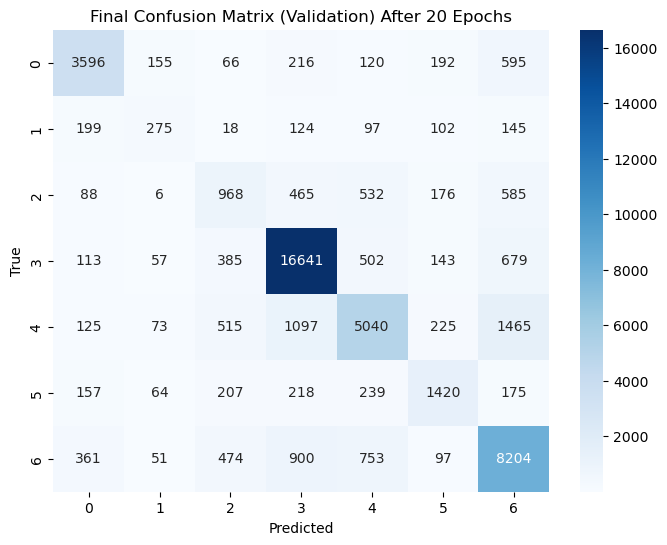

In [14]:
# Confusion matrix
final_cm = confusion_matrix(cumulative_labels, cumulative_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(final_cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(7), yticklabels=range(7))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Final Confusion Matrix (Validation) After 20 Epochs')
plt.show()